In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import ndarray
import re
from NNR import NeuralNetworkRegression

In [2]:
random_state = 42

In [3]:
def get_data(file_path: str) -> tuple:
    with open(file_path, "r") as file:
        data = file.readlines()

    # Przetwarzanie danych wejściowych i wyjściowych
    x_data, y_data = zip(*[map(float, line.split()) for line in data])
    x_data, y_data = np.array(x_data), np.array(y_data)

    scaler = MinMaxScaler()
    x_data_scaled = scaler.fit_transform(x_data.reshape(-1, 1))
    y_data_scaled = scaler.fit_transform(y_data.reshape(-1, 1))

    x_train, x_test, y_train, y_test = train_test_split(
        x_data_scaled, y_data_scaled, test_size=0.2
    )

    return x_train, x_test, y_train, y_test

In [4]:
def plot_data(
        neural_network: NeuralNetworkRegression,
        x_train: ndarray,
        x_test: ndarray,
        y_train: ndarray,
        y_test: ndarray,
) -> None:
    output_train = neural_network.predict(x_train)
    output_test = neural_network.predict(x_test)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(x_train, y_train, color="blue", label="Train data")
    plt.scatter(x_train, output_train, color="red", label="Predicted data")
    plt.title("Train data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(x_test, y_test, color="blue", label="Test data")
    plt.scatter(x_test, output_test, color="red", label="Predicted data")
    plt.title("Test data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

Fitting complete!


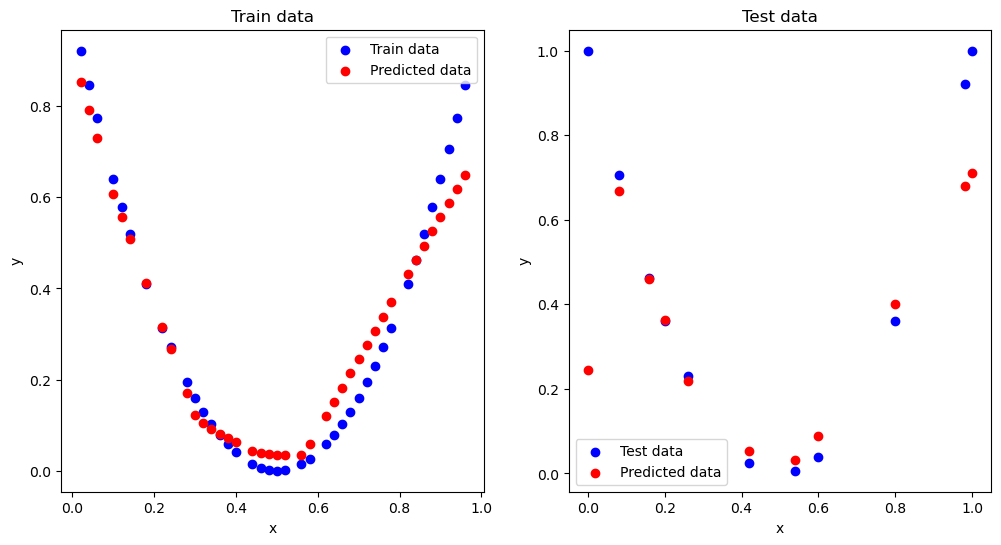

In [5]:
x_train, x_test, y_train, y_test = get_data("../data/data_test.txt")

neural_network = NeuralNetworkRegression(
    1, 300, 1, NeuralNetworkRegression.relu, NeuralNetworkRegression.relu_derivative
)
neural_network.train(x_train, y_train, 10000, 0.01, 0.01)

plot_data(neural_network, x_train, x_test, y_train, y_test)

In [6]:
from typing import Callable


class DataAnalyzer:
    def __init__(self, file_path: str, random_state: int = 42):
        self.file_path = file_path
        self.random_state = random_state
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

    def load_data(self) -> ndarray:
        data = np.array([])
        with open(self.file_path, "r") as file:
            for line in file:
                data = np.append(data, [float(x) for x in line.strip().split()])
        return data.reshape(-1, 2)

    def split_data(self, data: ndarray) -> tuple:
        x_data, y_data = data[:, 0], data[:, 1]
        x_data_scaled = self.scaler_x.fit_transform(x_data.reshape(-1, 1))
        y_data_scaled = self.scaler_y.fit_transform(y_data.reshape(-1, 1))
        return train_test_split(
            x_data_scaled, y_data_scaled, test_size=0.2, random_state=self.random_state
        )

    def train_network(
        self,
        x_train,
        y_train,
        epochs,
        learning_rate,
        reg_l2,
        network_size: tuple[int, int, int],
        activation_function: Callable,
        activation_function_derivative: Callable,
    ) -> None:
        self.neural_network = NeuralNetworkRegression(
            *network_size,
            activation_function,
            activation_function_derivative,
        )

        self.neural_network.train(
            x_train.reshape(-1, 1),
            y_train.reshape(-1, 1),
            epochs,
            learning_rate,
            reg_l2,
        )

    def plot_data(
        self,
        x_train,
        y_train,
        x_test,
        y_test,
        output_train,
        output_test,
        data_notes: dict,
        is_save: bool,
    ) -> None:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.plot(self.neural_network.history_mse, color="blue", label="MSE")
        plt.title(f"Final Mean Squared Error: {self.neural_network.history_mse[-1]}")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.subplot(2, 2, 2)
        plt.plot(self.neural_network.history_r2, color="blue", label="R2")
        plt.title(f"Final R2 Score: {self.neural_network.history_r2[-1]}")
        plt.xlabel("Epochs")
        plt.ylabel("R2")
        plt.subplot(2, 2, 3)
        plt.scatter(x_train, y_train, color="blue", label="Train data")
        plt.scatter(x_train, output_train, color="red", label="Predicted data (Train)")
        plt.scatter(x_test, y_test, color="green", label="Test data")
        plt.scatter(x_test, output_test, color="orange", label="Predicted data (Test)")
        plt.title(
            f"Neurons: {self.neural_network.input_size + self.neural_network.hidden_size + self.neural_network.output_size}, Epochs: {self.neural_network.epoch_num_c}, Learning rate: {self.neural_network.learning_rate}, Reg L2: {self.neural_network.reg_l2}"
        )
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.tight_layout()

        font_size = 15
        wrap = False
        function_act = data_notes["function_act"]
        plt.figtext(0.6, 0.4, function_act, wrap=wrap, fontsize=font_size)

        function_act_der = data_notes["function_act_der"]
        plt.figtext(0.6, 0.36, function_act_der, wrap=wrap, fontsize=font_size)

        weights_note = data_notes["weights_note"]
        plt.figtext(0.6, 0.32, weights_note, wrap=wrap, fontsize=font_size)

        bias_note = data_notes["bias_note"]
        plt.figtext(0.6, 0.28, bias_note, wrap=wrap, fontsize=font_size)

        rest_note = data_notes["rest_note"]
        plt.figtext(0.6, 0.12, rest_note, wrap=True, fontsize=font_size)

        if is_save:
            data_num = re.findall(r"\d+", self.file_path)
            plt.savefig(f"../result/output_data{data_num}.png")

    def analyze_data(
        self,
        epochs: int,
        learning_rate: float,
        reg_l2: float,
        network_size: tuple[int, int, int],
        activation_function: Callable,
        activation_function_derivative: Callable,
        data_notes: dict,
        is_save: bool = False,
    ) -> None:

        data = self.load_data()
        x_train, x_test, y_train, y_test = self.split_data(data)
        self.train_network(
            x_train,
            y_train,
            epochs,
            learning_rate,
            reg_l2,
            network_size,
            activation_function,
            activation_function_derivative,
        )

        output_train = self.neural_network.predict(x_train.reshape(-1, 1))

        output_test = self.neural_network.predict(x_test.reshape(-1, 1))
        self.plot_data(
            x_train,
            y_train,
            x_test,
            y_test,
            output_train,
            output_test,
            data_notes,
            is_save,
        )

In [7]:
files_path = [
    # "../data/data_test.txt",
    "../data/dane4.txt",
    "../data/dane7.txt",
    "../data/dane9.txt",
    "../data/dane15.txt",
    "../data/dane16.txt",
]

Epoch 5000 of 50000
MSE: 0.008609114200237857, R2: 0.9039978612211222
Epoch 10000 of 50000
MSE: 0.008403701095732984, R2: 0.9062884682344584
Epoch 15000 of 50000
MSE: 0.00831304719095842, R2: 0.9072993700002608
Epoch 20000 of 50000
MSE: 0.008236676749047085, R2: 0.9081509937088619
Epoch 25000 of 50000
MSE: 0.008165282028622288, R2: 0.9089471320453832
Epoch 30000 of 50000
MSE: 0.008097625526793098, R2: 0.9097015846785844
Epoch 35000 of 50000
MSE: 0.00803323040033756, R2: 0.9104196689928217
Epoch 40000 of 50000
MSE: 0.007971846290105857, R2: 0.911104176798412
Epoch 45000 of 50000
MSE: 0.007913123074751706, R2: 0.9117590123760161
Epoch 50000 of 50000
MSE: 0.007856775366343792, R2: 0.9123873581496497
Fitting complete!


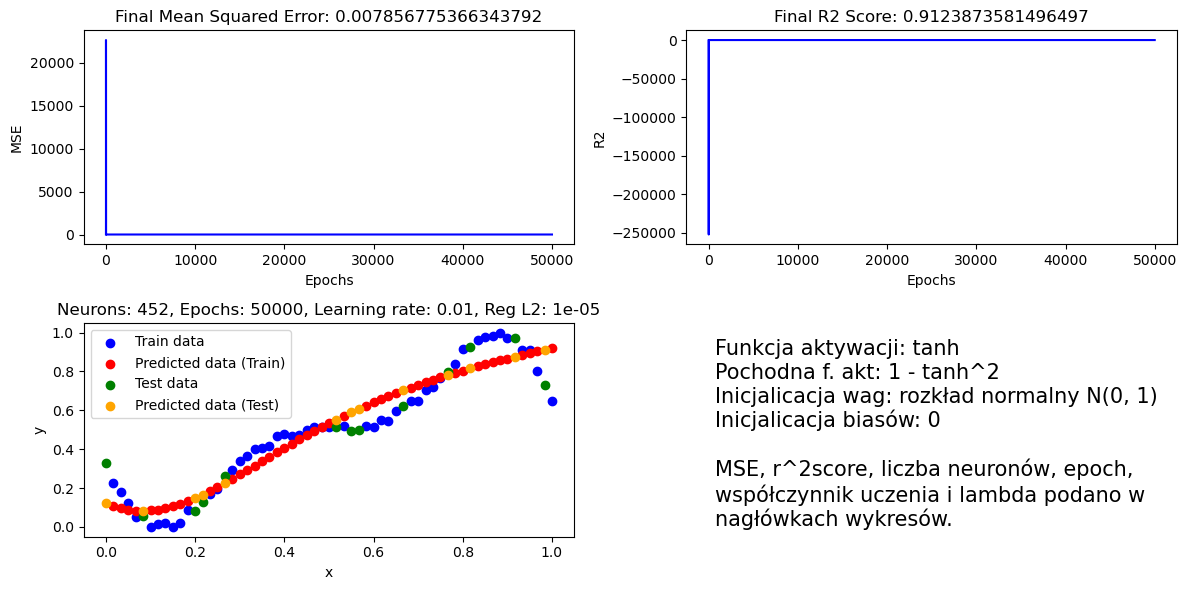

In [43]:
data_notes = {
    "function_act": "Funkcja aktywacji: tanh",
    "function_act_der": "Pochodna f. akt: 1 - tanh^2",
    "weights_note": "Inicjalicacja wag: rozkład normalny N(0, 1)",
    "bias_note": "Inicjalicacja biasów: 0",
    "rest_note": "MSE, r^2score, liczba neuronów, epoch, współczynnik uczenia i lambda podano w nagłówkach wykresów.",
}

data_analyzer = DataAnalyzer(files_path[0])

data_analyzer.analyze_data(
    epochs=50_000,
    learning_rate=0.01,
    reg_l2=0.00001,
    network_size=(1, 450, 1),
    activation_function=NeuralNetworkRegression.tanh,
    activation_function_derivative=NeuralNetworkRegression.tanh_derivative,
    data_notes=data_notes,
    is_save=True,
)

Epoch 9000 of 90000
MSE: 0.028153709006524495, R2: 0.581394396023913
Epoch 18000 of 90000
MSE: 0.026069154337231386, R2: 0.6123887586550814
Epoch 27000 of 90000
MSE: 0.024454922980940333, R2: 0.6363900826618316
Epoch 36000 of 90000
MSE: 0.022438019376701094, R2: 0.6663785701900096
Epoch 45000 of 90000
MSE: 0.02143720431695545, R2: 0.681259266458345
Epoch 54000 of 90000
MSE: 0.020718599350273714, R2: 0.6919439000896832
Epoch 63000 of 90000
MSE: 0.020124126884455647, R2: 0.7007828600129835
Epoch 72000 of 90000
MSE: 0.019618304778576498, R2: 0.7083037151900732
Epoch 81000 of 90000
MSE: 0.01921364777132495, R2: 0.7143203892590009
Epoch 90000 of 90000
MSE: 0.018868552694749498, R2: 0.7194514621462558
Fitting complete!


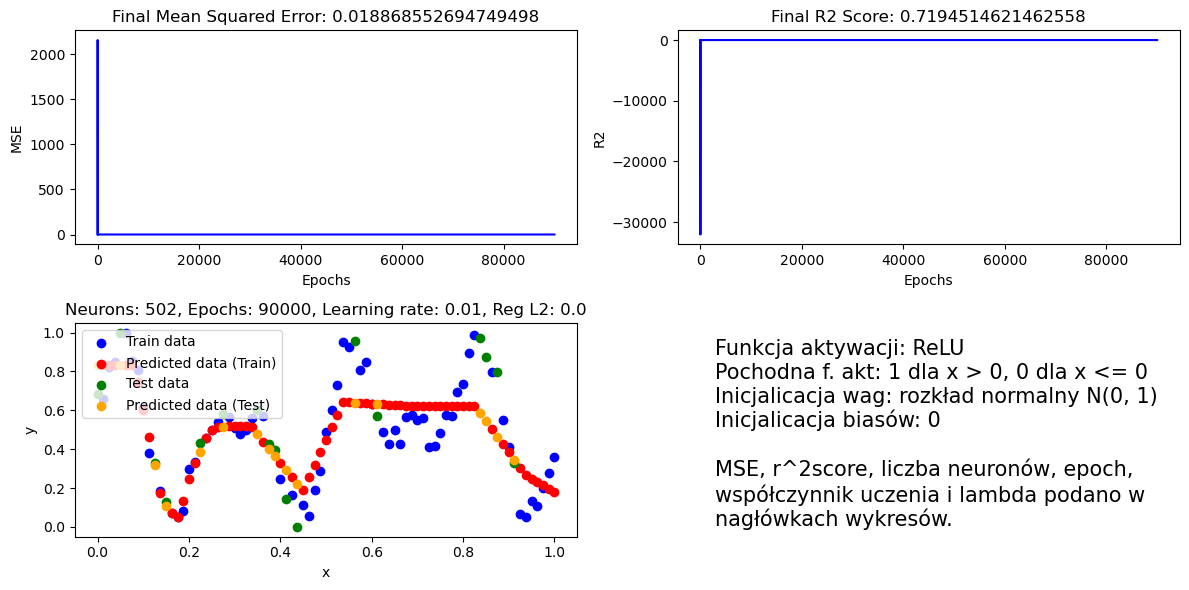

In [39]:
data_notes = {
    "function_act": "Funkcja aktywacji: ReLU",
    "function_act_der": "Pochodna f. akt: 1 dla x > 0, 0 dla x <= 0",
    "weights_note": "Inicjalicacja wag: rozkład normalny N(0, 1)",
    "bias_note": "Inicjalicacja biasów: 0",
    "rest_note": "MSE, r^2score, liczba neuronów, epoch, współczynnik uczenia i lambda podano w nagłówkach wykresów.",
}

data_analyzer = DataAnalyzer(files_path[1])

data_analyzer.analyze_data(
    epochs=90_000,
    learning_rate=0.01,
    reg_l2=0.000,
    network_size=(1, 500, 1),
    activation_function=NeuralNetworkRegression.relu,
    activation_function_derivative=NeuralNetworkRegression.relu_derivative,
    data_notes=data_notes,
    is_save=True,
)

Epoch 2000 of 20000
MSE: 0.022085724844996706, R2: 0.704046414802509
Epoch 4000 of 20000
MSE: 0.02139707328165384, R2: 0.7132744976729406
Epoch 6000 of 20000
MSE: 0.020910032548128867, R2: 0.7198009509469695
Epoch 8000 of 20000
MSE: 0.02051702650271401, R2: 0.7250673186555741
Epoch 10000 of 20000
MSE: 0.020174819883349807, R2: 0.72965296284837
Epoch 12000 of 20000
MSE: 0.01986472685230715, R2: 0.7338082778731617
Epoch 14000 of 20000
MSE: 0.01957770597672896, R2: 0.7376544209248412
Epoch 16000 of 20000
MSE: 0.019308721166646187, R2: 0.7412588767199924
Epoch 18000 of 20000
MSE: 0.019054549961249577, R2: 0.7446648269443581
Epoch 20000 of 20000
MSE: 0.01881290219879872, R2: 0.7479029602704863
Fitting complete!


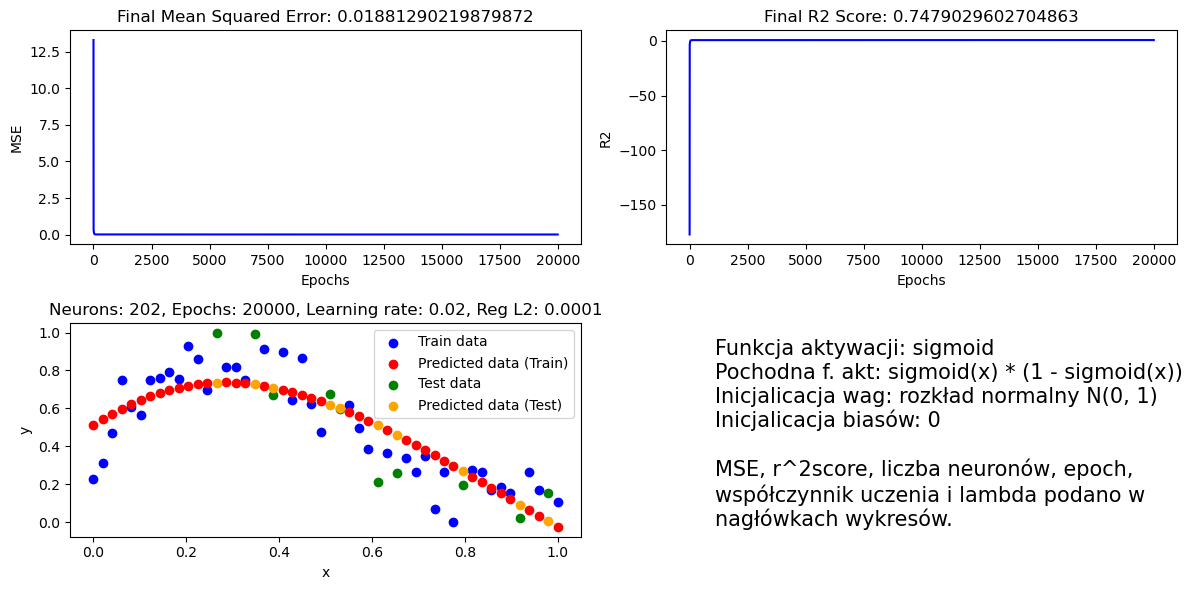

In [46]:
data_notes = {
    "function_act": "Funkcja aktywacji: sigmoid",
    "function_act_der": "Pochodna f. akt: sigmoid(x) * (1 - sigmoid(x))",
    "weights_note": "Inicjalicacja wag: rozkład normalny N(0, 1)",
    "bias_note": "Inicjalicacja biasów: 0",
    "rest_note": "MSE, r^2score, liczba neuronów, epoch, współczynnik uczenia i lambda podano w nagłówkach wykresów.",
}

data_analyzer = DataAnalyzer(files_path[2])

data_analyzer.analyze_data(
    epochs=20_000,
    learning_rate=0.02,
    reg_l2=0.0001,
    network_size=(1, 200, 1),
    activation_function=NeuralNetworkRegression.sigmoid,
    activation_function_derivative=NeuralNetworkRegression.sigmoid_derivative,
    data_notes=data_notes,
    is_save=True,
)

Epoch 9000 of 90000
MSE: 0.08642845305493957, R2: -0.0024578370258958593
Epoch 18000 of 90000
MSE: 0.08614783541291851, R2: 0.000796963268550277
Epoch 27000 of 90000
MSE: 0.08608396943576119, R2: 0.001537725680206381
Epoch 36000 of 90000
MSE: 0.08603264693058346, R2: 0.002133000103300642
Epoch 45000 of 90000
MSE: 0.0859900619020811, R2: 0.0026269311416710073
Epoch 54000 of 90000
MSE: 0.08595440590351348, R2: 0.0030404944294272207
Epoch 63000 of 90000
MSE: 0.08592456886535901, R2: 0.0033865653317095568
Epoch 72000 of 90000
MSE: 0.0858996229612671, R2: 0.0036759054294981386
Epoch 81000 of 90000
MSE: 0.08587904405467299, R2: 0.003914594026407037
Epoch 90000 of 90000
MSE: 0.08586213316025468, R2: 0.004110738444611295
Fitting complete!


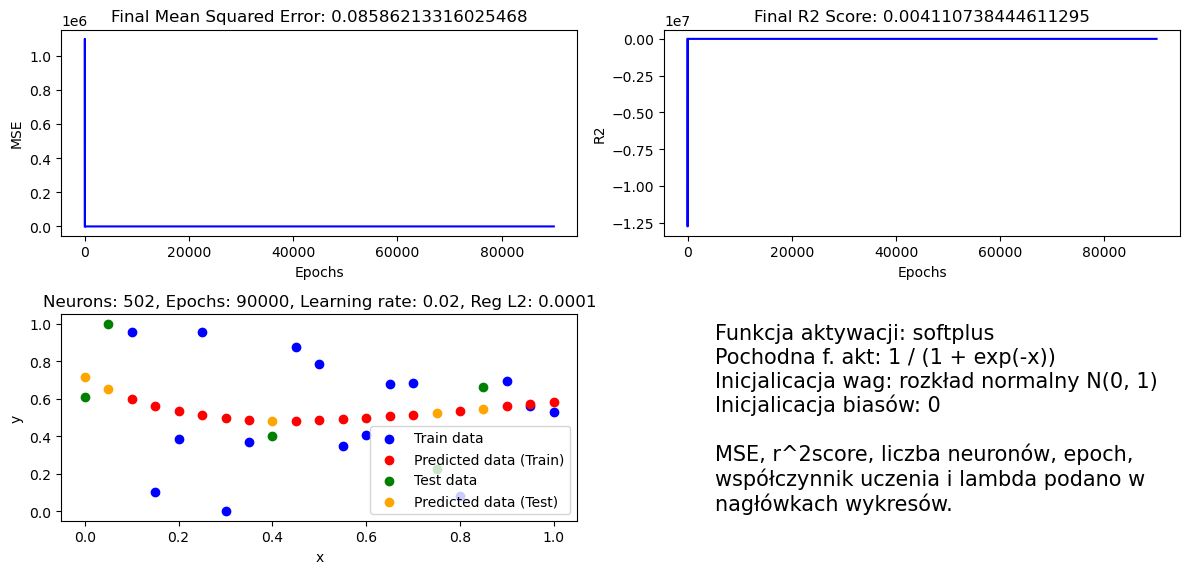

In [54]:
data_notes = {
    "function_act": "Funkcja aktywacji: softplus",
    "function_act_der": "Pochodna f. akt: 1 / (1 + exp(-x))",
    "weights_note": "Inicjalicacja wag: rozkład normalny N(0, 1)",
    "bias_note": "Inicjalicacja biasów: 0",
    "rest_note": "MSE, r^2score, liczba neuronów, epoch, współczynnik uczenia i lambda podano w nagłówkach wykresów.",
}

data_analyzer = DataAnalyzer(files_path[3])

data_analyzer.analyze_data(
    epochs=90000,
    learning_rate=0.02,
    reg_l2=0.0001,
    network_size=(1, 500, 1),
    activation_function=NeuralNetworkRegression.softplus,
    activation_function_derivative=NeuralNetworkRegression.softplus_derivative,
    data_notes=data_notes,
    is_save=True,
)

Epoch 7000 of 70000
MSE: 0.03186154152928717, R2: 0.6041621115254818
Epoch 14000 of 70000
MSE: 0.028618522569527814, R2: 0.6444523710577766
Epoch 21000 of 70000
MSE: 0.026051693303616688, R2: 0.6763418600129455
Epoch 28000 of 70000
MSE: 0.023637964861608227, R2: 0.7063292719200961
Epoch 35000 of 70000
MSE: 0.021328097544164367, R2: 0.7350263454986867
Epoch 42000 of 70000
MSE: 0.01905795491901086, R2: 0.7632298918478414
Epoch 49000 of 70000
MSE: 0.01694355918763113, R2: 0.7894984871993737
Epoch 56000 of 70000
MSE: 0.014973960417066562, R2: 0.8139681701168069
Epoch 63000 of 70000
MSE: 0.013214121497671897, R2: 0.8358318618427121
Epoch 70000 of 70000
MSE: 0.011621581955789386, R2: 0.8556170781038743
Fitting complete!


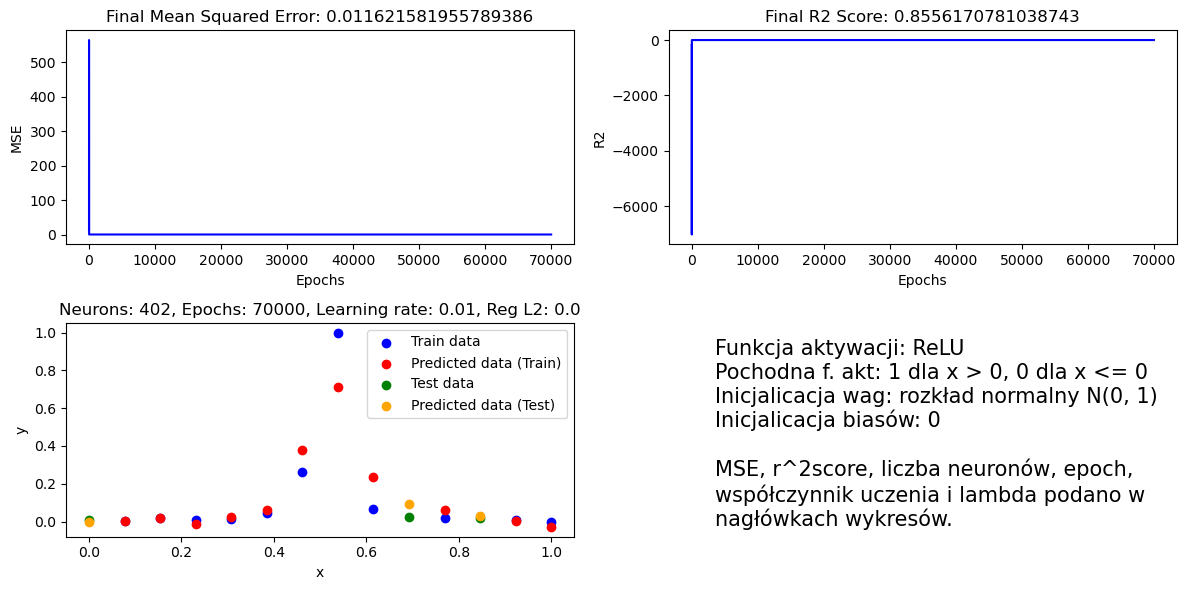

In [57]:
data_notes = {
    "function_act": "Funkcja aktywacji: ReLU",
    "function_act_der": "Pochodna f. akt: 1 dla x > 0, 0 dla x <= 0",
    "weights_note": "Inicjalicacja wag: rozkład normalny N(0, 1)",
    "bias_note": "Inicjalicacja biasów: 0",
    "rest_note": "MSE, r^2score, liczba neuronów, epoch, współczynnik uczenia i lambda podano w nagłówkach wykresów.",
}

data_analyzer = DataAnalyzer(files_path[4])

data_analyzer.analyze_data(
    epochs=70_000,
    learning_rate=0.01,
    reg_l2=0.0,
    network_size=(1, 400, 1),
    activation_function=NeuralNetworkRegression.relu,
    activation_function_derivative=NeuralNetworkRegression.relu_derivative,
    data_notes=data_notes,
    is_save=True,
)